In [1]:
import os
import cv2
import json
import glob
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm import tqdm
from natsort import natsorted

from scipy import signal
from scipy.io import wavfile
from scipy.ndimage import sobel

import librosa
import librosa.display

In [2]:
def log_spectrogram(audio, sample_rate, window_size=20,
                    step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    freqs, _, spec = signal.spectrogram(
        audio,
        fs=sample_rate,
        window='hann',
        nperseg=nperseg,
        noverlap=noverlap,
        detrend=False
    )

    return freqs, np.log(spec.T.astype(np.float32) + eps)


def audio2spectrogram(filepath: str) -> np.ndarray:
    samplerate, test_sound = wavfile.read(filepath, mmap=True)

    _, spectrogram = log_spectrogram(test_sound, samplerate)

    return spectrogram


def audio2wave(filepath) -> np.ndarray:
    _, test_sound = wavfile.read(filepath, mmap=True)

    return test_sound


def gradients_channels(grayscale_array: np.ndarray) -> np.ndarray:
    gradient_x = sobel(grayscale_array, axis=0)
    gradient_y = sobel(grayscale_array, axis=1)

    return np.stack([grayscale_array, gradient_x, gradient_y], axis=-1)


def get_3d_spectrogram(Sxx_in, moments=None):
    if moments is not None:
        (base_mean, base_std, delta_mean, delta_std,
             delta2_mean, delta2_std) = moments
    else:
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)

    h, w = Sxx_in.shape

    right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
    delta = (Sxx_in - right1)[:, 1:]
    delta_pad = delta[:, 0].reshape((h, -1))
    delta = np.concatenate([delta_pad, delta], axis=1)

    right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
    delta2 = (delta - right2)[:, 1:]
    delta2_pad = delta2[:, 0].reshape((h, -1))
    delta2 = np.concatenate([delta2_pad, delta2], axis=1)

    base = (Sxx_in - base_mean) / base_std
    delta = (delta - delta_mean) / delta_std
    delta2 = (delta2 - delta2_mean) / delta2_std

    stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]

    return np.concatenate(stacked, axis=2)

In [3]:
def select_major_emotion(emotion_vector: np.array) -> np.array:
    """
    Returns the major emotion based on significance while retaining the original order.

    :param emotion_vector: List of binary values representing emotions.
    :return: A new binary vector with only the major emotion set to 1.
    """

    # Original order of emotions
    original_order = ["Curiosity", "Uncertainty", "Excitement", "Happiness",
                     "Surprise", "Disgust", "Fear", "Frustration"]

    # New order of significance
    new_order = ["Happiness", "Excitement", "Disgust", "Fear", "Frustration",
                 "Surprise", "Curiosity", "Uncertainty"]

    # Extract emotions from initial vector
    indicated_emotions = [original_order[i] for i, e in enumerate(emotion_vector) if e == 1]

    # Determine the most significant emotion from the new order
    for emotion in new_order:
        if emotion in indicated_emotions:
            major = emotion
            break

    # Create and return the new vector based on original order
    return np.array([1 if emotion == major else 0 for emotion in original_order])

In [10]:
def visualize_spectrogram(spectrogram, emotion_name, spec_name):
    fig = plt.figure(figsize=(10, 6))
    plt.grid(False)
    plt.imshow(spectrogram.T[:, :], aspect='auto', origin='lower', cmap="viridis")

    plt.ylabel("Hz")
    plt.xlabel("Time (ms)")
    plt.title(f"{spec_name} of emotion *{emotion_name}*")
    plt.show()

def visualize_emotion(spectrogram, emotion_name, spec_name):
    fig = plt.figure(figsize=(10, 6))
    plt.grid(False)
    plt.imshow(spectrogram.T[:, :, :], aspect='auto', origin='lower', cmap="magma")

    plt.ylabel("Hz")
    plt.xlabel("Time (ms)")
    plt.title(f"{spec_name} of emotion *{emotion_name}*")
    plt.show()

def visualize_wave(_wave, emotion_name, spec_name):
    fig = plt.figure(figsize=(10, 6))
    plt.grid(False)
    plt.plot(_wave)

    plt.ylabel("Amplitude")
    plt.xlabel("Sample Index")
    plt.title(f"{spec_name} of emotion *{emotion_name}*")
    plt.show()

In [5]:
with open(os.path.join(os.getcwd(), "data_path_config.json"), "r") as f:
    config = json.load(f)

config

{'raw_data': 'D:\\Projects\\masters_diploma\\data\\raw\\EmoReact',
 'processed_data': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact',
 'videos': 'D:\\Projects\\masters_diploma\\data\\raw\\EmoReact\\videos',
 'visual_features': 'D:\\Projects\\masters_diploma\\data\\raw\\EmoReact\\visual_features',
 'datasets': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\datasets',
 'datasets_videos': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\datasets\\videos',
 'datasets_visual_features': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\datasets\\visual_features',
 'images': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\images',
 'datasets_images': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\datasets\\images',
 'audio': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\audio',
 'datasets_audio': 'D:\\Projects\\masters_diploma\\data\\processed\\EmoReact\\datasets\\audio',
 'audio_216k': 'D:\\Projects\\masters_diplo

In [6]:
emotion_dict = {
    0: "Curiosity",
    1: "Uncertainty",
    2: "Excitement",
    3: "Happiness",
    4: "Surprise",
    5: "Disgust",
    6: "Fear",
    7: "Frustration"
}

In [7]:
dataset_name = "Train"
df = pd.read_csv(os.path.join(config["datasets_audio_216k"], "train.csv"))

# Drop cases, where there are no detected emotions
df = df[df.iloc[:, 1:-1].eq(1).any(axis=1)]

emotions_agg = []
for el_id in range(len(df.index)):
    _labels_list = np.array(df.iloc[el_id, 1:-1].values, dtype=int)
    _label = select_major_emotion(emotion_vector=_labels_list)
    emotions_agg.append(np.argmax(_label))

df["major_emotion"] = emotions_agg
df

file_path  Curiosity  \
0    D:\Projects\masters_diploma\data\processed\Emo...          0   
1    D:\Projects\masters_diploma\data\processed\Emo...          0   
4    D:\Projects\masters_diploma\data\processed\Emo...          0   
6    D:\Projects\masters_diploma\data\processed\Emo...          0   
7    D:\Projects\masters_diploma\data\processed\Emo...          0   
..                                                 ...        ...   
427  D:\Projects\masters_diploma\data\processed\Emo...          1   
428  D:\Projects\masters_diploma\data\processed\Emo...          1   
429  D:\Projects\masters_diploma\data\processed\Emo...          1   
430  D:\Projects\masters_diploma\data\processed\Emo...          1   
431  D:\Projects\masters_diploma\data\processed\Emo...          1   

     Uncertainty  Excitement  Happiness  Surprise  Disgust  Fear  Frustration  \
0              0           0          1         0        0     0            0   
1              0           1          1         0        0     0            0   
4              0           0          1         0        0     0            0   
6              0           1          1         0        0     0            0   
7              0           1          1         0        0     0            0   
..           ...         ...        ...       ...      ...   ...          ...   
427            1           0          1         1        0     0            0   
428            0           1          1         1        0     0            0   
429            1           0          1         0        0     0            0   
430            1           0          0         0        0     0            0   
431            1           0          1         1        0     0            0   

     Valence  major_emotion  
0     3.3333              3  
1     6.3333              3  
4     4.6667              3  
6     6.0000              3  
7     5.0000              3  
..       ...            ...  
427   4.6667              3  
428   5.6667              3  
429   5.3333              3  
430   4.3333              0  
431   5.3333              3  

[370 rows x 11 columns]

In [8]:
emotion_num = 0

df_emotion = df[df["major_emotion"] == emotion_num]
df_emotion

file_path  Curiosity  \
9    D:\Projects\masters_diploma\data\processed\Emo...          1   
10   D:\Projects\masters_diploma\data\processed\Emo...          1   
33   D:\Projects\masters_diploma\data\processed\Emo...          1   
34   D:\Projects\masters_diploma\data\processed\Emo...          1   
80   D:\Projects\masters_diploma\data\processed\Emo...          1   
130  D:\Projects\masters_diploma\data\processed\Emo...          1   
144  D:\Projects\masters_diploma\data\processed\Emo...          1   
152  D:\Projects\masters_diploma\data\processed\Emo...          1   
173  D:\Projects\masters_diploma\data\processed\Emo...          1   
198  D:\Projects\masters_diploma\data\processed\Emo...          1   
199  D:\Projects\masters_diploma\data\processed\Emo...          1   
202  D:\Projects\masters_diploma\data\processed\Emo...          1   
231  D:\Projects\masters_diploma\data\processed\Emo...          1   
239  D:\Projects\masters_diploma\data\processed\Emo...          1   
251  D:\Projects\masters_diploma\data\processed\Emo...          1   
278  D:\Projects\masters_diploma\data\processed\Emo...          1   
291  D:\Projects\masters_diploma\data\processed\Emo...          1   
299  D:\Projects\masters_diploma\data\processed\Emo...          1   
302  D:\Projects\masters_diploma\data\processed\Emo...          1   
336  D:\Projects\masters_diploma\data\processed\Emo...          1   
341  D:\Projects\masters_diploma\data\processed\Emo...          1   
357  D:\Projects\masters_diploma\data\processed\Emo...          1   
359  D:\Projects\masters_diploma\data\processed\Emo...          1   
361  D:\Projects\masters_diploma\data\processed\Emo...          1   
379  D:\Projects\masters_diploma\data\processed\Emo...          1   
404  D:\Projects\masters_diploma\data\processed\Emo...          1   
405  D:\Projects\masters_diploma\data\processed\Emo...          1   
415  D:\Projects\masters_diploma\data\processed\Emo...          1   
430  D:\Projects\masters_diploma\data\processed\Emo...          1   

     Uncertainty  Excitement  Happiness  Surprise  Disgust  Fear  Frustration  \
9              1           0          0         0        0     0            0   
10             0           0          0         0        0     0            0   
33             0           0          0         0        0     0            0   
34             1           0          0         0        0     0            0   
80             1           0          0         0        0     0            0   
130            0           0          0         0        0     0            0   
144            0           0          0         0        0     0            0   
152            1           0          0         0        0     0            0   
173            0           0          0         0        0     0            0   
198            1           0          0         0        0     0            0   
199            0           0          0         0        0     0            0   
202            1           0          0         0        0     0            0   
231            0           0          0         0        0     0            0   
239            0           0          0         0        0     0            0   
251            1           0          0         0        0     0            0   
278            0           0          0         0        0     0            0   
291            0           0          0         0        0     0            0   
299            1           0          0         0        0     0            0   
302            0           0          0         0        0     0            0   
336            1           0          0         0        0     0            0   
341            0           0          0         0        0     0            0   
357            1           0          0         0        0     0            0   
359            1           0          0         0        0     0            0   
361            1           0  

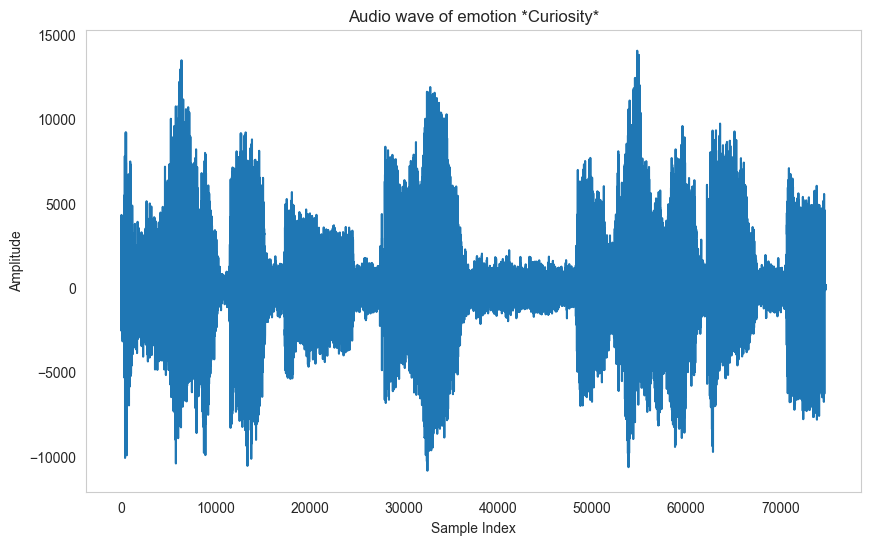

In [11]:
_audio_wave = audio2wave(filepath=df_emotion["file_path"].to_list()[8])
visualize_wave(_audio_wave, emotion_dict[emotion_num], "Audio wave")

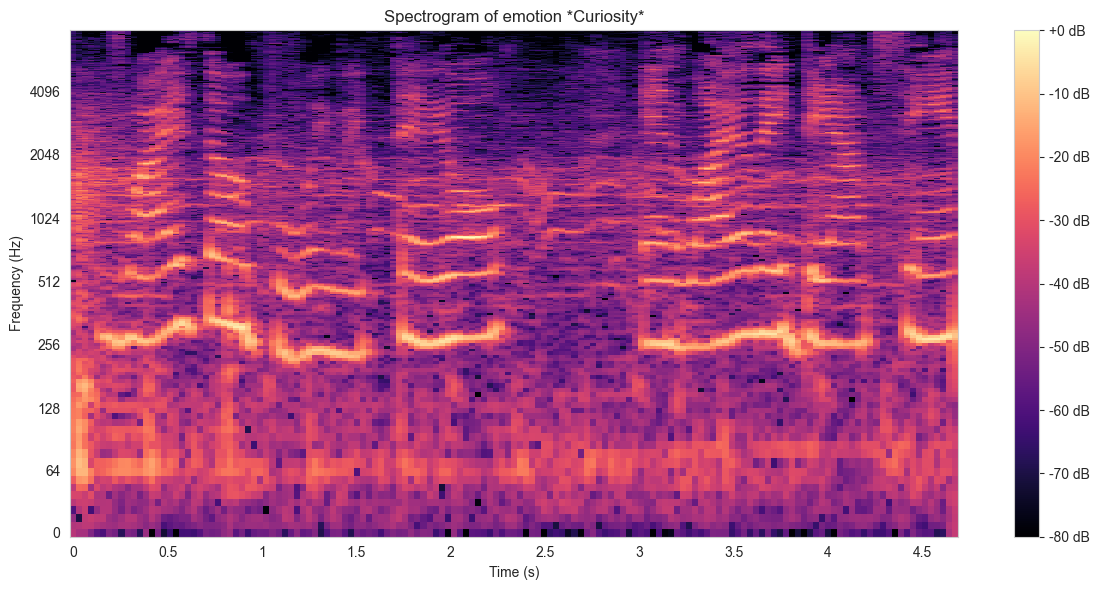

In [12]:
# Load the .wav file
y, sr = librosa.load(df_emotion["file_path"].to_list()[8], sr=None)

# Compute the spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Display the spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of emotion *Curiosity*')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

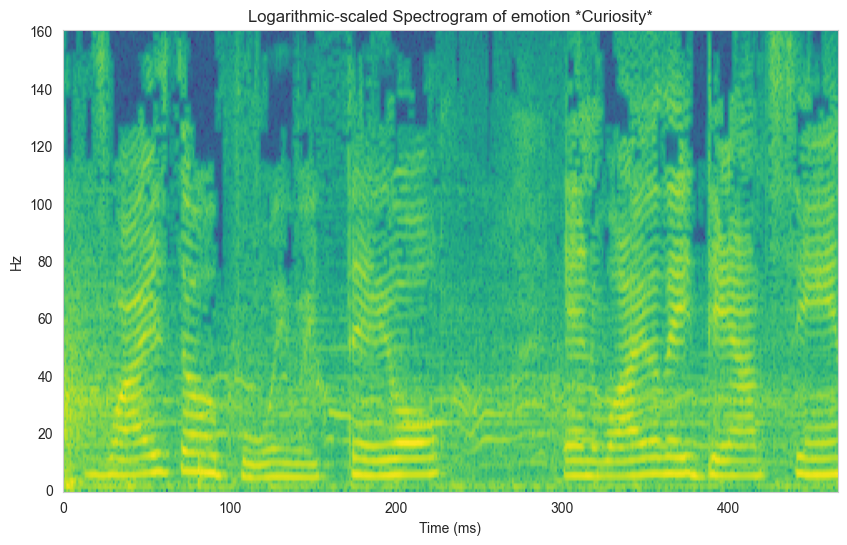

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


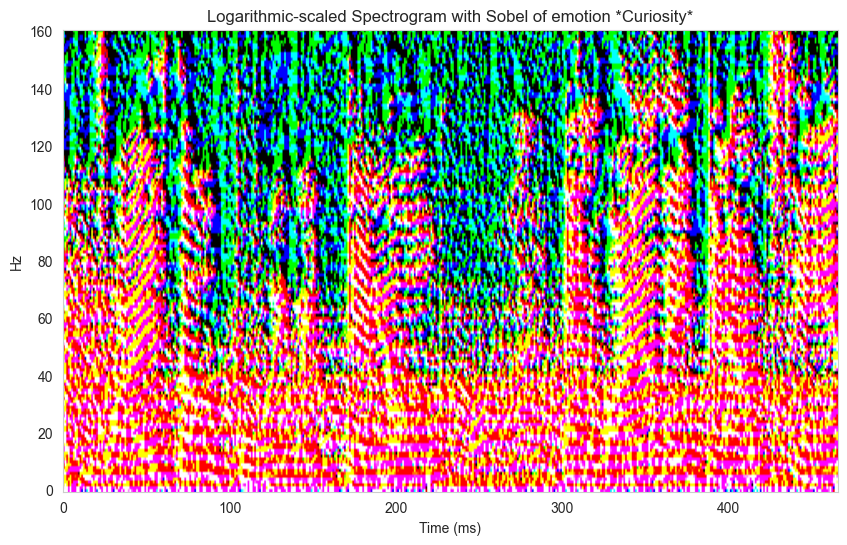

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


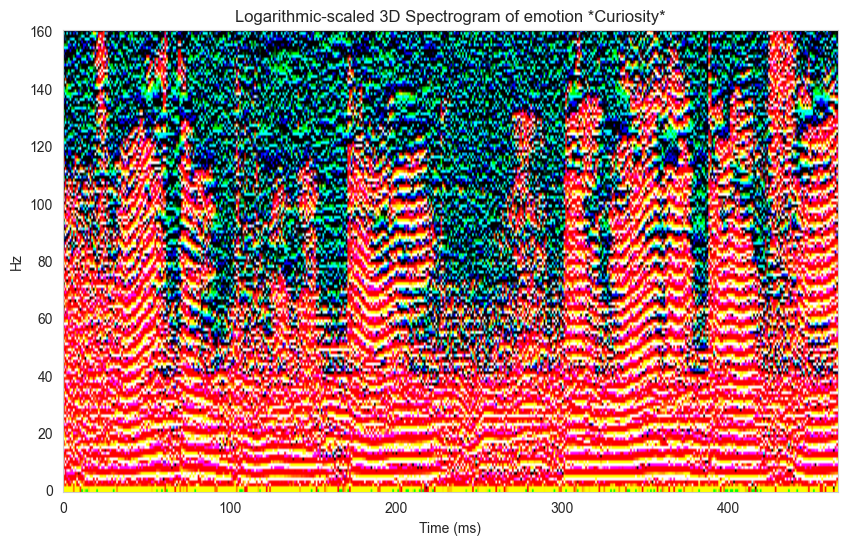

In [13]:
_audio_spectrogram = audio2spectrogram(filepath=df_emotion["file_path"].to_list()[8])
visualize_spectrogram(_audio_spectrogram, emotion_dict[emotion_num], "Logarithmic-scaled Spectrogram")

# Sobel 3D
_audio_spectrogram_3d_sobel = gradients_channels(_audio_spectrogram)
visualize_emotion(_audio_spectrogram_3d_sobel.transpose(2, 0, 1), emotion_dict[emotion_num], "Logarithmic-scaled Spectrogram with Sobel")

# 3D
_audio_spectrogram_3d = get_3d_spectrogram(_audio_spectrogram)
visualize_emotion(_audio_spectrogram_3d.transpose(2, 0, 1), emotion_dict[emotion_num], "Logarithmic-scaled 3D Spectrogram")

# Visualization of sobel gradients

In [14]:
def gradients_channels_return_grad(grayscale_array: np.ndarray):
    gradient_x = sobel(grayscale_array, axis=0)
    gradient_y = sobel(grayscale_array, axis=1)

    return np.stack([grayscale_array, gradient_x, gradient_y], axis=-1), gradient_x, gradient_y

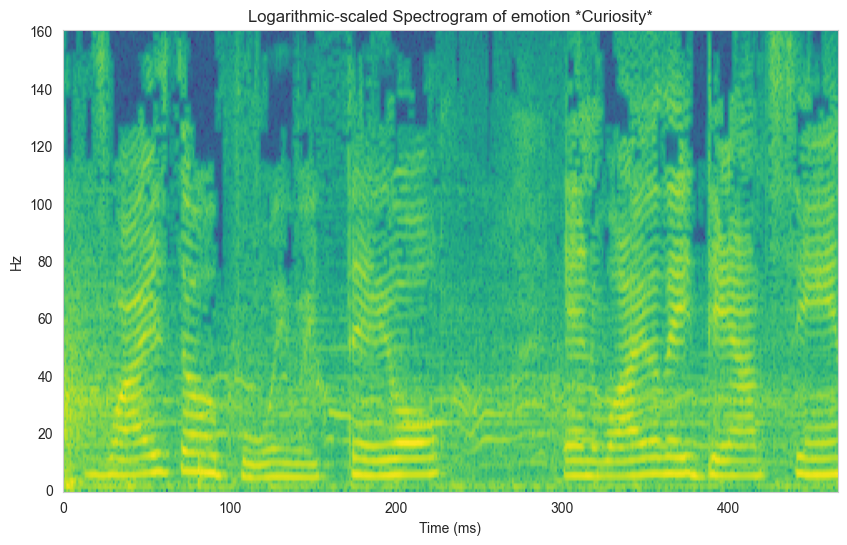

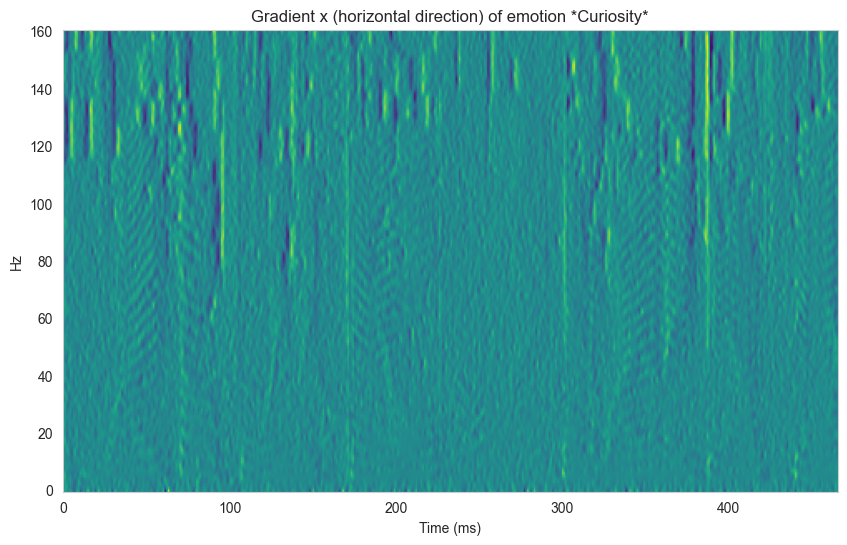

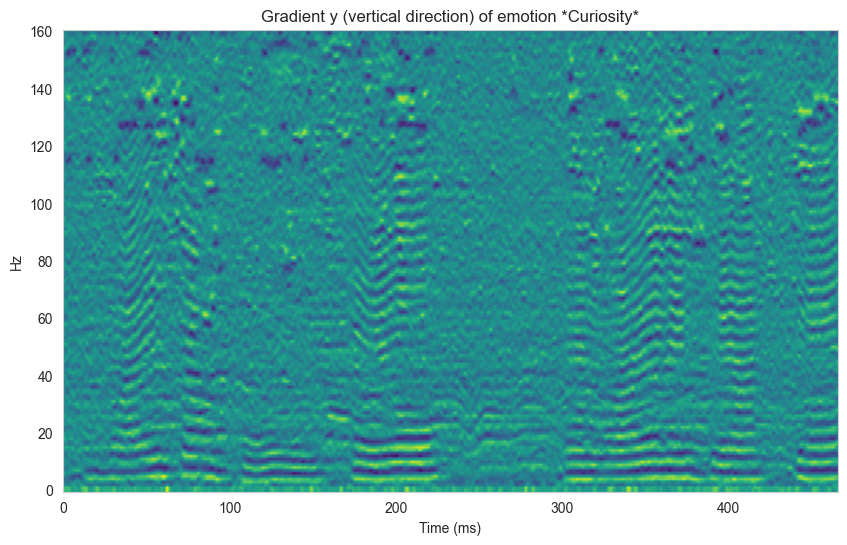

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


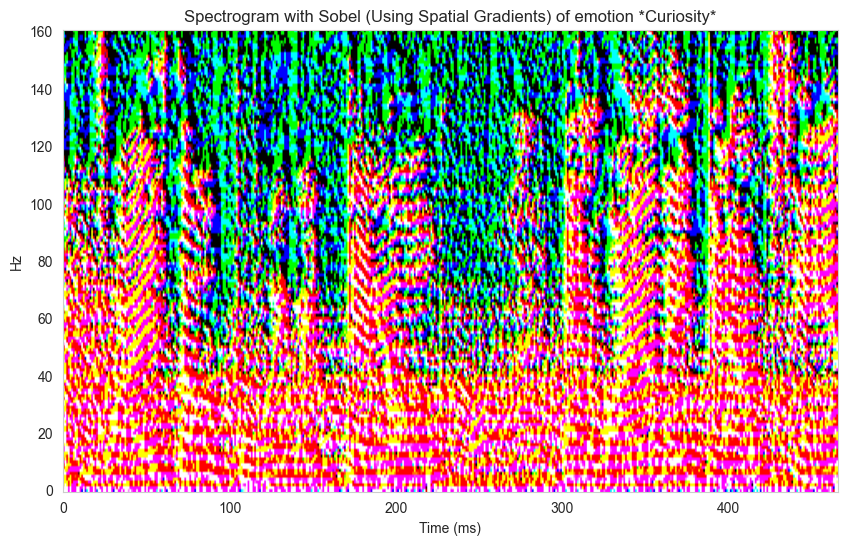

In [15]:
_audio_spectrogram = audio2spectrogram(filepath=df_emotion["file_path"].to_list()[8])
visualize_spectrogram(_audio_spectrogram, emotion_dict[emotion_num], "Logarithmic-scaled Spectrogram")

# Sobel 3D
_audio_spectrogram_3d_sobel, gradient_x, gradient_y = gradients_channels_return_grad(_audio_spectrogram)

visualize_spectrogram(gradient_x, emotion_dict[emotion_num], "Gradient x (horizontal direction)")
visualize_spectrogram(gradient_y, emotion_dict[emotion_num], "Gradient y (vertical direction)")

visualize_emotion(_audio_spectrogram_3d_sobel.transpose(2, 0, 1), emotion_dict[emotion_num], "Spectrogram with Sobel (Using Spatial Gradients)")

In [16]:
def get_3d_spectrogram(Sxx_in, moments=None):
    if moments is not None:
        (base_mean, base_std, delta_mean, delta_std,
             delta2_mean, delta2_std) = moments
    else:
        base_mean, delta_mean, delta2_mean = (0, 0, 0)
        base_std, delta_std, delta2_std = (1, 1, 1)

    h, w = Sxx_in.shape

    right1 = np.concatenate([Sxx_in[:, 0].reshape((h, -1)), Sxx_in], axis=1)[:, :-1]
    delta = (Sxx_in - right1)[:, 1:]
    delta_pad = delta[:, 0].reshape((h, -1))
    delta = np.concatenate([delta_pad, delta], axis=1)

    right2 = np.concatenate([delta[:, 0].reshape((h, -1)), delta], axis=1)[:, :-1]
    delta2 = (delta - right2)[:, 1:]
    delta2_pad = delta2[:, 0].reshape((h, -1))
    delta2 = np.concatenate([delta2_pad, delta2], axis=1)

    base = (Sxx_in - base_mean) / base_std
    delta = (delta - delta_mean) / delta_std
    delta2 = (delta2 - delta2_mean) / delta2_std

    stacked = [arr.reshape((h, w, 1)) for arr in (base, delta, delta2)]

    return np.concatenate(stacked, axis=2), delta, delta2

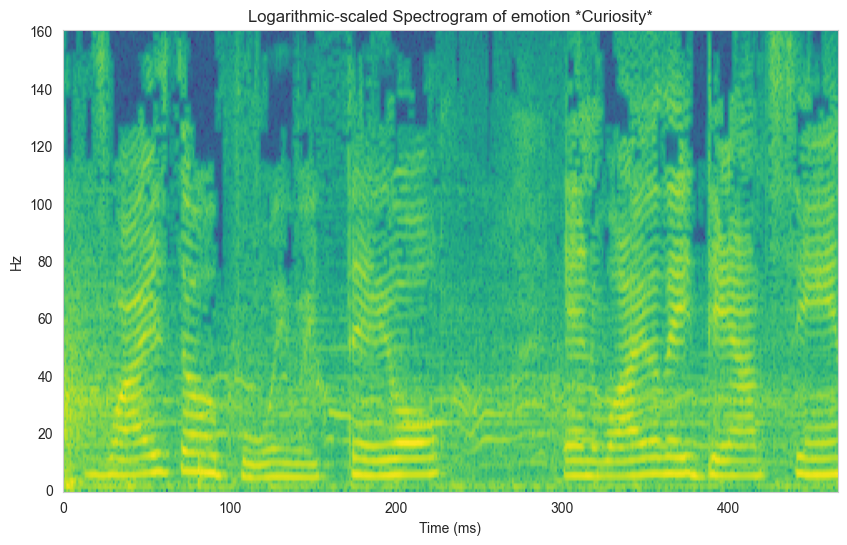

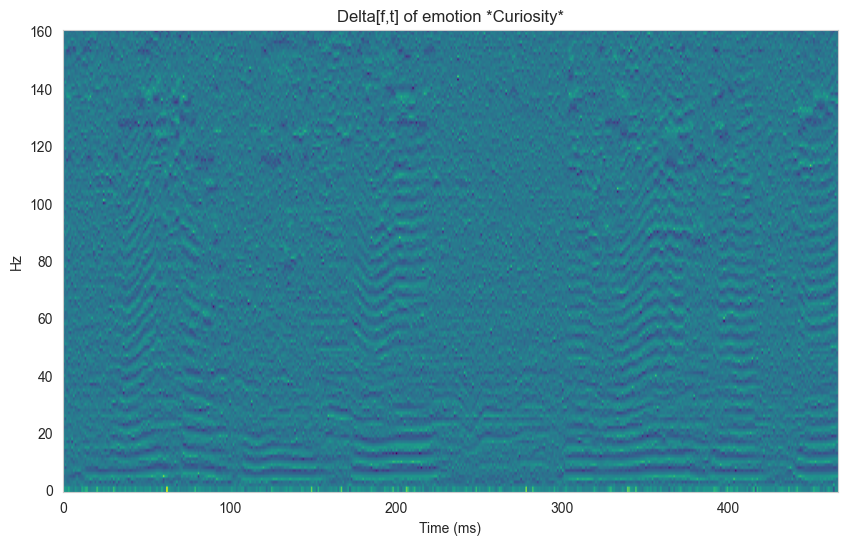

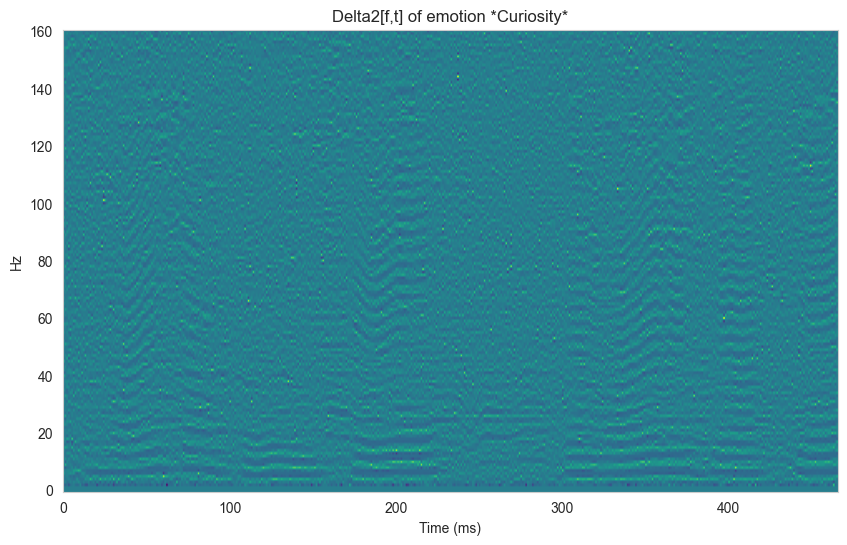

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


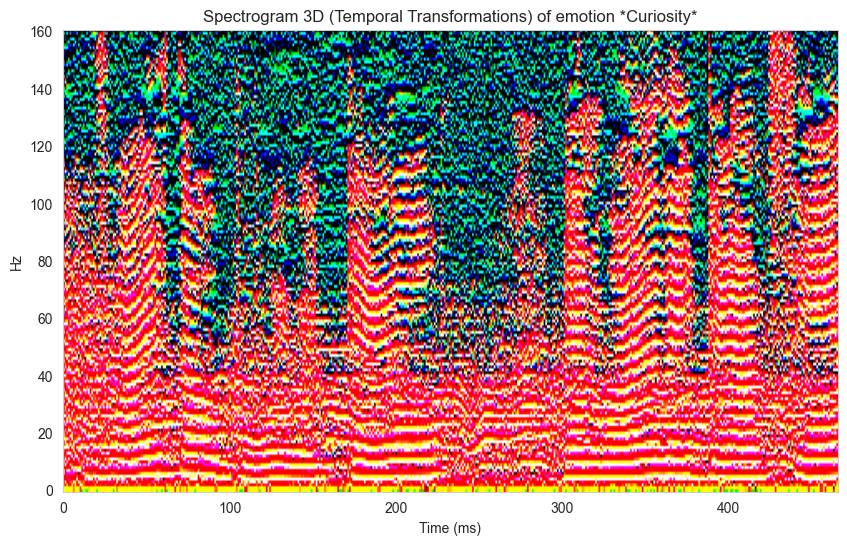

In [18]:
_audio_spectrogram = audio2spectrogram(filepath=df_emotion["file_path"].to_list()[8])
visualize_spectrogram(_audio_spectrogram, emotion_dict[emotion_num], "Logarithmic-scaled Spectrogram")

# Sobel 3D
_audio_spectrogram_3d_2, delta, delta_2 = get_3d_spectrogram(_audio_spectrogram)

visualize_spectrogram(delta, emotion_dict[emotion_num], "Delta[f,t]")
visualize_spectrogram(delta_2, emotion_dict[emotion_num], "Delta2[f,t]")

visualize_emotion(_audio_spectrogram_3d_2.transpose(2, 0, 1), emotion_dict[emotion_num], "Spectrogram 3D (Temporal Transformations)")